<a href="https://colab.research.google.com/github/sanka-eu/nonlinear_and_adaptive_control_practice/blob/main/shishkin_cource_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Шишкин Александр Эдуардович, группа 0391, Курсовой проект

# 1. Система с пид-регулятором
Средства автоматизации расчетов и моделироаания систем управления в среде Python/scipy

### Модель системы

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;30tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе

### 1. Автоматизация расчета закона управления с помощью пакета sympy

Зададим два уравнения, описывающие систему, в коде. Допускается, что аргументы тангенса находятся в окресности нуля, поэтому заменяем тангенс на простую линейную зависимость ($\;tanh\left(I\right) -> I\;$).

In [31]:
import sympy
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta=sympy.symbols('zeta')
I=sympy.symbols('I')

#запись уравнений
d_dP=17 * T + zeta - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + 30 * I - 1

#печать сивольных выражений
print('Уравнения системы:')
print('dP/dt=' + str(d_dP))
print('dT/dt=' + str(dT))
print('')

Уравнения системы:
dP/dt=17*T - 0.1*dP**3 + zeta + 9*sin(4*dP - 7) - 6
dT/dt=30*I - 0.1*T**3 - 2*T*cos(5*dP + 6) - 1



Определим эталонную модель процесса

$\dot{dP}\;-\;13.5\;+\;0.1dP^3\;-\;9\sin\left(4dP\;-\;7\right)\;+\;6=\;17T_d$\
За управляющее воздействие примем $17T_d$, поделим на $17$ в конце всех преобразований.

In [32]:
from sympy.solvers import solve
#вводим символ производной скорости изменения давления
ddP=sympy.symbols('ddP')
#решаем уравнение относительно 17T, "перенося" ddP вправо со знаком "-"
currentModel = solve(d_dP - ddP, 17*T)[0];
print("currentModel = " + str(currentModel));

currentModel = 0.1*dP**3 + ddP - zeta - 9.0*sin(4.0*dP - 7.0) + 6.0


Составим формулу эталонной модели с неизвестными коэффициентами

In [33]:
#определим неизвестные коэффициенты эталонной модели
C1=sympy.symbols('C1')
C2=sympy.symbols('C2')

#определим эталонную модель
etalonModel = ddP + C1 * dP + C2
print("etalonModel: " + str(etalonModel) + " = 0")
#решаем уравнение относительно управляющего воздействия U(dP,C1,C2)
U=sympy.symbols('U')
solution_U = solve((-currentModel + ddP) + U - (-etalonModel + ddP), U)[0]
print("solution_U: U = " + str(solution_U))

etalonModel: C1*dP + C2 + ddP = 0
solution_U: U = -C1*dP - C2 + 0.1*dP**3 - zeta - 9.0*sin(4.0*dP - 7.0) + 6.0


Расчитаем коэффициенты эталонной модели

In [34]:
#уравнение модели в положении равновесия
etalonBalance = -(etalonModel - ddP)
etalonBalanceSolution = solve(etalonBalance, dP)[0]
print(etalonBalance)
print("dP_d = " + str(etalonBalanceSolution))

-C1*dP - C2
dP_d = -C2/C1


Перенос в систему координат, у которой положение равновесия в нуле

In [35]:
#уравнение для переноса в новую систему координат
dP_d=sympy.symbols('dP_d')
dP_d1=dP_d + etalonBalanceSolution
print("dP_d1 = " + str(dP_d1))

#подставляем это уравнение в эталонную модель вместо dP
etalonModelNewCoordinates = (-etalonModel + ddP).subs({dP : dP_d1})
print("etalonModelNewCoordinates = " + str(sympy.expand(etalonModelNewCoordinates)))

#тогда матрица преобразований будет
print([-C1])

#находим определитель матрицы |A - E*L|, где A - матрица преобразований, L - собственные числа
L=sympy.symbols('L')
determinant = -C1 - L
print("L = ", solve(determinant, L)[0])

#вещественная часть собственных чисел должна быть < 0 => C1 > 0
#выберем C1 = 1, тогда C2 = -dP_d*C1 = -dP_d
#подставим полученные коэффициенты в функцию управляющего воздействия
U = solution_U.subs({C1: -1, C2: 1*dP_d})
print("U = ", U)

dP_d1 = dP_d - C2/C1
etalonModelNewCoordinates = -C1*dP_d
[-C1]
L =  -C1
U =  0.1*dP**3 + dP - dP_d - zeta - 9.0*sin(4.0*dP - 7.0) + 6.0


Проверка алгоритма управления

In [36]:
#подставим полученную функцию управления в исходную модель объекта
currentModelWithNewU = currentModel - U
print("currentModelWithNewU = ", currentModelWithNewU)
#приравниваем производную к нулю и решаем уравнение относительно dP (находим решение в положении равновесия)
equilibriumSolution = solve(currentModelWithNewU - ddP, dP)[0]
print("dP = " + str(equilibriumSolution))

currentModelWithNewU =  -dP + dP_d + ddP
dP = dP_d


Получаем, что в положении равновесия значение равно желаемому.

Определим устойчивость системы в окрестности нуля

In [37]:
#посчитаем собственные числа, подставим вместо dP -> (y - dP_d)
#перенос координат в 0 (y = dP - dP_d)
y=sympy.symbols('y')
zeroEquilibriumCoordinatesModel = (currentModelWithNewU - ddP).subs({dP: (y - dP_d)})
print("d(ddP(y)) / dy = " + str(sympy.diff(zeroEquilibriumCoordinatesModel, y)))

d(ddP(y)) / dy = -1


Получаем, что в окрестности нуля система устойчива

Запишем полученное уравнение эталонной модели и условие равенства движения системы и эталона

$\dot {dP_d} = dP_d - dP$

$\dot {dP} - \dot {dP_d} = 0$

Найдём жедаемое значение T_d для полученной эталонной модели. Для этого нужно решить уравнение равенства движения системы и эталона относительно T.

In [38]:
from sympy.solvers import solve
d_dP_d=dP_d-dP
T_d=(solve(d_dP-d_dP_d, 17*T)[0]) * (1 / 17)
print('Желаемая функция T_d(t) для эталонной модели d_dP_d = '+str(d_dP_d))
print('T_d = '+str(T_d))
print('')

Желаемая функция T_d(t) для эталонной модели d_dP_d = -dP + dP_d
T_d = 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588



Определим функцию psi исходя из равенства желаемого и реального поведения системы под воздействием управления.\
Найдем производную по каждой из координат для psi (dP и T) и найдем закон управления для переменной тока I.

In [39]:
psi=T_d-T
print("psi = " + str(psi))
dpsi=sympy.diff(psi,dP)*d_dP + sympy.diff(psi,T)*dT
print("dpsi = " + str(dpsi))
u=solve(sympy.expand(dpsi+psi),I)
u_analytical = u[0]
print('Закон управления по методу АКАР для макропеременной psi=' + str(psi))
print('I='+str(u_analytical))
print()

psi = -T + 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588
dpsi = -30*I + 0.1*T**3 + 2*T*cos(5*dP + 6) + (0.0176470588235294*dP**2 - 2.11764705882353*cos(4.0*dP - 7.0) - 0.0588235294117647)*(17*T - 0.1*dP**3 + zeta + 9*sin(4*dP - 7) - 6) + 1
Закон управления по методу АКАР для макропеременной psi=-T + 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588
I=0.00333333333333333*T**3 + 0.01*T*dP**2 - 1.2*T*cos(4.0*dP - 7.0) + 0.0666666666666667*T*cos(5.0*dP + 6.0) - 0.0666666666666667*T - 5.88235294117647e-5*dP**5 + 0.00705882352941176*dP**3*cos(4.0*dP - 7.0) + 0.000392156862745098*dP**3 + 0.000588235294117647*dP**2*zeta + 0.00529411764705882*dP**2*sin(4.0*dP - 7.0) - 0.00352941176470588*dP**2 - 0.00196078431372549*dP + 0.00196078431372549*dP_d - 0.0705882352941176*zeta*cos(

### 2. Численное моделирование системы ОДУ

Ещё раз запишем уравнения системы:

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;30tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе

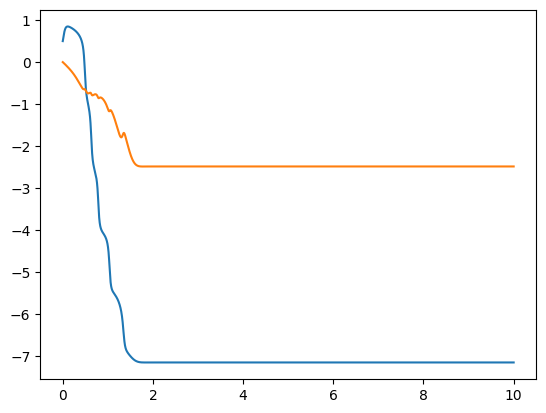

In [40]:
import matplotlib.pyplot as plt
import scipy.integrate as mdl
import math
import numpy as np

#определим функцию для некотролируемого возмущения от времени
def zetaFunction(t):
    return (t % 19) + 4
#определим воздействие на систему (силу тока I на нагревательном элементе)
u = 0.001
#определим коэффициент перед управляющим воздействием
G = 30
#определим функцию, описывающую уравнения системы
def F(x, t, u, G):
    #zeta = zetaFunction(t)
    zeta = 4
    d_dP = 17*x[1] + zeta - 0.1*x[0]**3 + 9*math.sin(4*x[0] - 7) - 6
    dT = -0.1*x[1]**3 - 2*x[1]*math.cos(5*x[0] + 6) + G*math.tanh(u) - 1
    return [d_dP, dT]

t = np.linspace(0, 10, 10000)
y = mdl.odeint(F, [0.5, 0.0], t, args=(u, G))

plt.plot(t,y)
plt.show()

На графике видно, что при начальных значениях близких к нулю и при малом управляющем воздействии система принимает отрицательные значения.\
Необходимо увеличить коэффициент перед управляющим воздействием (силу исполнительного механизма) на порядок выше.

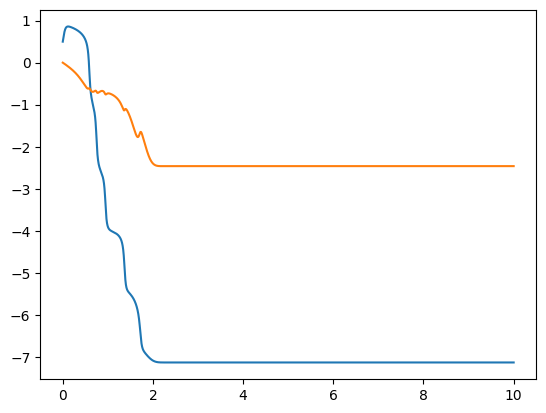

In [41]:
#зададим G = 300 вместо G = 30
G = 300
y = mdl.odeint(F, [0.5, 0.0], t, args=(u, G))
plt.plot(t,y)
plt.show()

График практически не отличается от предыдущего, продолжим увеличение коэффициента.

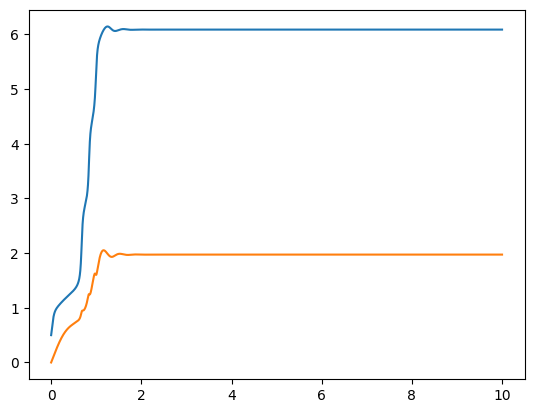

In [42]:
#зададим G = 3000 вместо G = 300
G = 3000
y = mdl.odeint(F, [0.5, 0.0], t, args=(u, G))
plt.plot(t,y)
plt.show()

Получаем, что ощутимое воздействие на систему будет оказывать исполнительный механизм, у которого коэффициент передачи больше на два порядка, чем в условии (при том условии, что сила тока измеряется в мА, в нашем случае `u = 0.001 = 1мА`).\
Примем коэффициент равный G = 3000.

### 3. Моделирование САУ с цифровым ПИ-регулятором


Базовый пакет для моделирования контроллера

In [43]:
!pip install digicon_mod

In [44]:
import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [45]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP = 17*x[1] + zeta - 0.1*x[0]**3 + 9*math.sin(4*x[0] - 7) - 6
            dT = -0.1*x[1]**3 - 2*x[1]*math.cos(5*x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

Реализация алгоритма ПИ-регулирования

In [46]:
class PI(digicon_mod.plc.PLC):
    def __init__(self, goal, Kp, Ki, gain, step):
        super(PI,self).__init__(gain, step)
        self.Ki = Ki
        self.Kp = Kp
        self.goal = goal
        self.ei = 0

    def control(self, x, t):
        e = x[0] - self.goal
        self.ei = self.ei + e
        return self.Kp * e + self.Ki * self.ei

Вывод результатов моделирования

In [47]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.show()

Программа моделирования

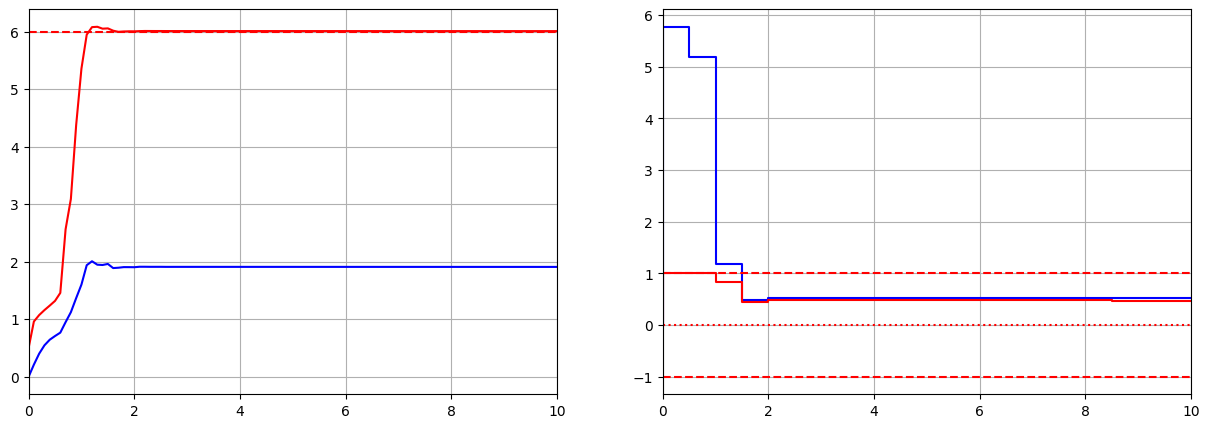

In [48]:
zeta_init = 4.0
zeta_finish = 23.0
change_time = 30
goal = 6
gain = 3
step = 0.5
mod_step = 0.1
func_ctrl = F_with_change(change_time,zeta_init,zeta_finish)

plc=PI(goal=goal, Kp=-1.0, Ki=-0.05, gain=gain, step=step)
tk=10
x0=[0.5, 0.0]
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)

При моделировании САУ с числовым ПИ-регулятором, были выявлены оптимальные значения для коэф.усиления регулятора и коэф.пропорциональной и интегральных частей.\
$gain=3,\;Kp=-0.1,\;Ki=-0.05$\
Так же система проверена работа системы для различных значений некотролируемого возмущения из диапазона по условию.

# 2. Метод аналитического конструирования агрегированных регуляторов (АКАР) с фиксацией неизвестного параметра на уровне среднего.
Системы с нелинейным законом управления и идентификацией параметров.

### 1. Модель системы и закон управления

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе\
G - коэффициент усиления исполнительного механизма

Сначала приведём расчет закона внутреннего управления для первого уравнения из отчёта первой лабораторной работы.

In [49]:
import sympy
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta=sympy.symbols('zeta')
I=sympy.symbols('I')
dP_d=sympy.symbols('dP_d')
G=sympy.symbols('G')

#запись уравнений
d_dP=17 * T + zeta - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + G * I - 1

from sympy.solvers import solve
d_dP_d=dP_d-dP
T_d=(solve(d_dP-d_dP_d, 17*T)[0]) * (1 / 17)
print('Желаемая функция T_d(t) для эталонной модели d_dP_d = '+str(d_dP_d))
print('T_d = '+str(T_d))
print('')

Желаемая функция T_d(t) для эталонной модели d_dP_d = -dP + dP_d
T_d = 0.00588235294117647*dP**3 - 0.0588235294117647*dP + 0.0588235294117647*dP_d - 0.0588235294117647*zeta - 0.529411764705882*sin(4.0*dP - 7.0) + 0.352941176470588



Можно определить значение некотролируемого возмущения, как медианное.\
В данном случае медианное значение равно:
$\zeta_0\;=\;13.5$\
Также не учитывать $Δζ$, предположить что оно незначительно

In [50]:
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')

psi_1 = d_dP_d
print(f'psi_1 = {str(psi_1)}')
dpsi_1 = sympy.diff(psi_1, dP)*d_dP
print(f'dpsi_1 = {str(dpsi_1)}')
T_i = solve(sympy.expand(T_1*dpsi_1 + psi_1), T)[0]
print(f'T = {str(T_i)}')
psi_2 = T_i - T
print(f'psi_2 = {str(psi_2)}')
dpsi_2 = sympy.diff(psi_2, dP)*d_dP + sympy.diff(psi_2,T)*dT
print(f'dpsi_2 = {str(dpsi_2)}')
u = solve(sympy.expand(T_2*dpsi_2 + psi_2), I)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'I = {str(u_analytical)}')

psi_1 = -dP + dP_d
dpsi_1 = -17*T + 0.1*dP**3 - zeta - 9*sin(4*dP - 7) + 6
T = 0.00588235294117647*(T_1*(dP**3 - 10.0*zeta - 90.0*sin(4.0*dP - 7.0) + 60.0) - 10.0*dP + 10.0*dP_d)/T_1
psi_2 = -T + 0.00588235294117647*(T_1*(dP**3 - 10.0*zeta - 90.0*sin(4.0*dP - 7.0) + 60.0) - 10.0*dP + 10.0*dP_d)/T_1
dpsi_2 = -G*I + 0.1*T**3 + 2*T*cos(5*dP + 6) + 1 + 0.00588235294117647*(T_1*(3*dP**2 - 360.0*cos(4.0*dP - 7.0)) - 10.0)*(17*T - 0.1*dP**3 + zeta + 9*sin(4*dP - 7) - 6)/T_1
psi_2 = -T + 0.00588235294117647*(T_1*(dP**3 - 10.0*zeta - 90.0*sin(4.0*dP - 7.0) + 60.0) - 10.0*dP + 10.0*dP_d)/T_1
I = 1.17647058823529e-18*(T_1*T_2*(8.5e+16*T**3 + 2.55e+17*T*dP**2 - 3.06e+19*T*cos(4.0*dP - 7.0) + 1.7e+18*T*cos(5.0*dP + 6.0) - 1.5e+15*dP**5 + 1.8e+17*dP**3*cos(4.0*dP - 7.0) + 1.5e+16*dP**2*zeta + 1.35e+17*dP**2*sin(4.0*dP - 7.0) - 9.0e+16*dP**2 - 1.8e+18*zeta*cos(4.0*dP - 7.0) - 8.1e+18*sin(8.0*dP - 14.0) + 1.08e+19*cos(4.0*dP - 7.0) + 8.5e+17) + 5.0e+15*T_1*(-170.0*T + dP**3 - 10.0*zeta - 90.0*sin(4.0*

### 2. Вспомогательные модули для моделирования


Базовый класс для моделирования контроллера

In [51]:
!pip install digicon_mod

In [52]:
import math
import numpy
import matplotlib.pyplot as plt
import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [53]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP=17 * x[1] + zeta - 0.1 * math.pow(x[0],3) + 9 * math.sin(4 * x[0] - 7) - 6
            dT=-0.1 * math.pow(x[1],3) - 2 * x[1] * math.cos(5 * x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

Вывод результатов моделирования

In [54]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

###3.  Моделирование САУ с аналитическим регулятором

In [55]:
list(u_analytical.free_symbols)

[dP_d, zeta, T_1, dP, T, G, T_2]

Инициализируем регулятор по методу AKAR в коде, возьмём значения T_1 > T_2, так как эталонная модель с T_2 ближе к реальному управляющему воздействию (силе тока в контуре).\
Т.е. регулирование T должно быть быстрее регулирования целевой переменной dP.

In [56]:
class AKAR(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dtu):
        super(AKAR,self).__init__(gain, dtu)
        self.G=gain
        self.Pd=goal
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        return self.func(
            dP=x[0], T=x[1], dP_d=self.Pd, zeta=13.5, T_1=100, T_2=1, G=self.G
        )

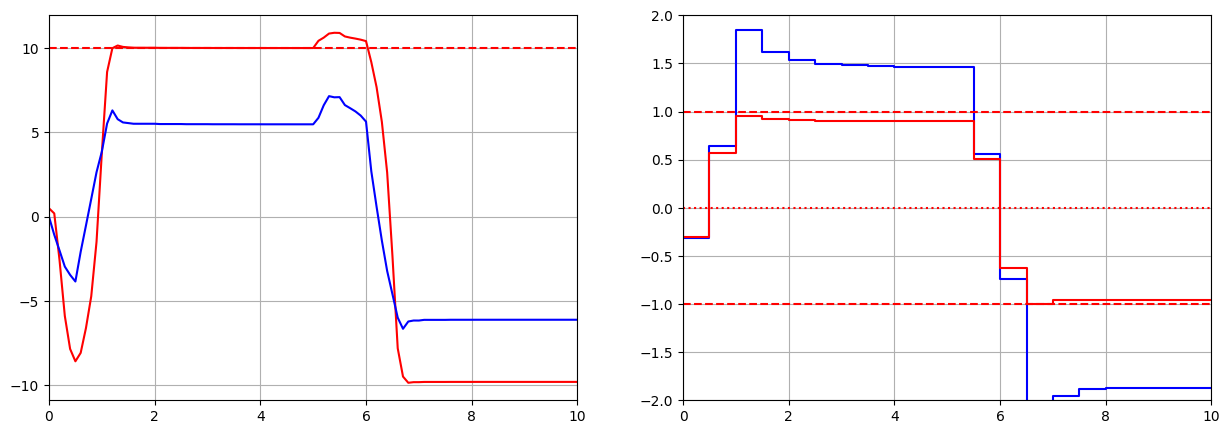

In [57]:
v0_init = 4.0
v0_finish = 23.0
change_time = 5
goal = 10
gain = 30
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc = AKAR(goal=goal, gain=gain, dtu=step)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=plc, goal=goal)

Процесс настройки включал в себя регулировку коэффициента усиления управляющего элемента, частоту управляющего воздействия (шаг упр.возд.).

В итоге оптимальные значения gain = 30, mod_step = 0.1

По графикам видно, что аналитический регулятор по методу АКАР не справляется с задачей управления без интегральной компоненты.

# 3. Метод аналитического конструирования агрегированных регуляторов (АКАР) с интегральной адаптацией.



$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе\
G - коэффициент усиления исполнительного механизма

Функции макропеременных:

$\psi_1 = dP - dP_d$

$\psi_2 = \psi_1 + z = dP - dP_d + z$

$\psi_3 = T_{internal} - T$

Эталонные модели:

$T_1 \dot \psi_2 + \psi_2 = 0$

$T_3 \dot \psi_3 + \psi_3 = 0$

Интегральная компонента

$\dot z = \frac 1 {T_2} \psi_1$

Параметр $v_0$:

$\zeta_0 = \zeta_{min} + \frac{(\zeta_{max}-\zeta_{min})}{2} = 4 + \frac{(23-4)}{2} = 13.5$

In [81]:
P = sympy.symbols('P')
T = sympy.symbols('T')
G = sympy.symbols('G')
I = sympy.symbols('I')
z = sympy.symbols('z')
dP_d = sympy.symbols('dP_d')
zeta0 = sympy.symbols('zeta0')
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')
T_3 = sympy.symbols('T_3')

#запись уравнений
d_dP=17 * T + zeta0 - 0.1 * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + G * I - 1

#метод акар с интегральной компонентой
psi_1 = dP - dP_d
dz = 1/T_2*psi_1
psi_2 = psi_1 + z
dpsi_2 = sympy.diff(psi_2, dP)*d_dP + sympy.diff(psi_2, z)*dz
T_i = solve(sympy.expand(T_1*dpsi_2 + psi_2),T)[0]
print(f'dz = {dz}')
print(f'T = {str(T_i)}')
psi_3 = T_i - T
dpsi_3 = sympy.diff(psi_3,dP)*d_dP + sympy.diff(psi_3,T)*dT + sympy.diff(psi_3,z)*dz
u = solve(sympy.expand(T_3*dpsi_3 + psi_3),I)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'psi_3 = {str(psi_3)}')
print(f'I = {str(u_analytical)}')

dz = (dP - dP_d)/T_2
T = 0.00588235294117647*(T_1*T_2*(dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 10.0*T_1*(-dP + dP_d) + 10.0*T_2*(-dP + dP_d - z))/(T_1*T_2)
psi_2 = dP - dP_d + z
psi_3 = -T + 0.00588235294117647*(T_1*T_2*(dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 10.0*T_1*(-dP + dP_d) + 10.0*T_2*(-dP + dP_d - z))/(T_1*T_2)
I = 1.17647058823529e-18*(T_1*T_2*T_3*(8.5e+16*T**3 + 2.55e+17*T*dP**2 - 3.06e+19*T*cos(4.0*dP - 7.0) + 1.7e+18*T*cos(5.0*dP + 6.0) - 1.5e+15*dP**5 + 1.8e+17*dP**3*cos(4.0*dP - 7.0) + 1.5e+16*dP**2*zeta0 + 1.35e+17*dP**2*sin(4.0*dP - 7.0) - 9.0e+16*dP**2 - 1.8e+18*zeta0*cos(4.0*dP - 7.0) - 8.1e+18*sin(8.0*dP - 14.0) + 1.08e+19*cos(4.0*dP - 7.0) + 8.5e+17) + 5.0e+15*T_1*T_2*(-170.0*T + dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 5.0e+15*T_1*T_3*(-170.0*T + dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 5.0e+16*T_1*(-dP + dP_d) + 5.0e+15*T_2*T_3*(-170.0*T + dP**3 - 10.0*zeta0 - 90.0*sin(4.0*dP - 7.0) + 60.0) + 5.0e+16*T_2*(-dP 

Выберем коэффициенты T_1 = 100, T_2 = 10, T_3 = 1

Подпрограмма для реализации нелинейного регулятора с интегральной компонентой.

In [82]:
print(list(u_analytical.free_symbols))

[dP_d, T_1, dP, T, T_3, zeta0, G, T_2, z]


In [83]:
class AKAR_i(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt, T1, T2, T3, zeta0):
        super(AKAR_i,self).__init__(gain, dt)
        self.dt = dt
        self.G=gain
        self.dP_d=goal
        self.T1 = T1
        self.T2 = T2
        self.T3 = T3
        self.zeta0 = zeta0
        self.z = []
        self.zt = []
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def control(self, x, t):
        dP = x[0]
        T = x[1]
        T_1 = self.T1
        T_2 = self.T2
        T_3 = self.T3
        dP_d = self.dP_d
        G = self.G
        zeta_0 = self.zeta0
        zeta0 = zeta_0
        dt = self.dt

        if len(self.z) < 1:
            z = 0.0
        else:
            z = self.z[-1] - dt/T_2*(dP - dP_d)
        self.z.append(z)
        self.zt.append(t)
        return self.func(
            G=G, dP=dP, zeta0=zeta0, dP_d=dP_d, z=z, T=T, T_3=T_3, T_1=T_1, T_2=T_2
        )

Моделирование и результаты.

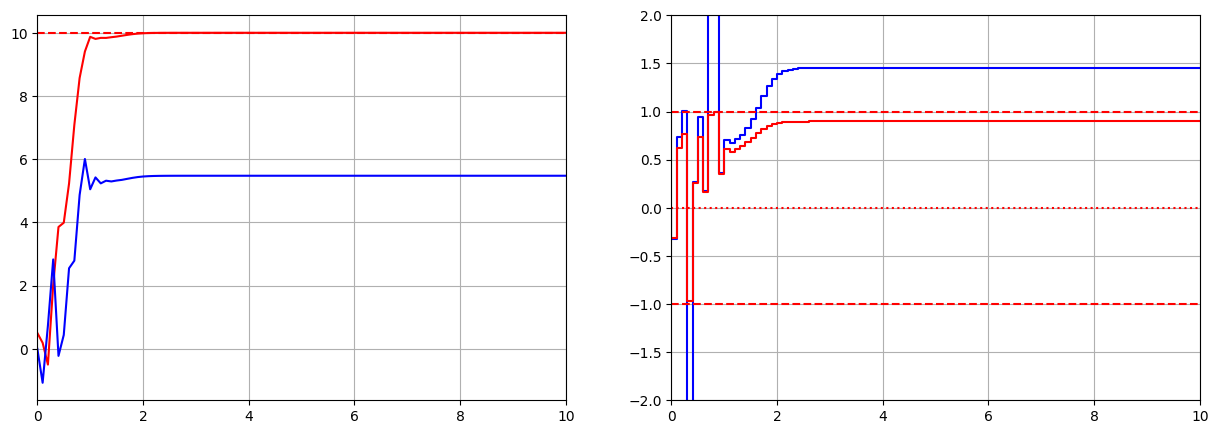

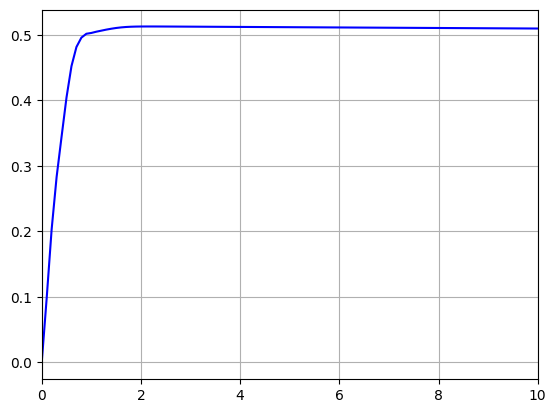

In [89]:
tk=10
reg = AKAR_i(goal=10, gain=30, dt=0.1, T1=100, T2=10, T3=1, zeta0=13.5)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=reg.dP_d)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.grid()
plt.show()

Процесс настройки включал в себя регулировку коэффициента усиления управляющего элемента, частоту управляющего воздействия (шаг упр.возд.).

В итоге оптимальные значения gain = 30, dt = 0.1

Система с интегральной компонентой приходит к желаемому значению.

# 4. Метод аналитического конструирования агрегированных регуляторов (АКАР) с идентификацией неизменяемого параметра.
Система с идентификацией параметров.

### 1. Модель системы и закон управления

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

где:\
T - температура\
dP - изменение давления газа в резервуаре\
I - сила тока, протекающего через нагревательный элемент\
ζ ∈ [4;23] - некотролируемое возмущение в системе\
G - коэффициент усиления исполнительного механизма

In [90]:
import sympy
from sympy.solvers import solve
#создание символьных переменных
dP=sympy.symbols('dP')
T=sympy.symbols('T')
zeta0=sympy.symbols('zeta0')
I=sympy.symbols('I')
dP_d=sympy.symbols('dP_d')
G=sympy.symbols('G')
a = sympy.symbols('a')

#запись уравнений
d_dP=17 * T + zeta0 + a * dP**3 + 9 * sympy.sin(4 * dP - 7) - 6
dT=-0.1 * T**3 - 2 * T * sympy.cos(5 * dP + 6) + G * I - 1

d_dP_d=dP-dP_d

T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')

psi_1 = d_dP_d
dpsi_1 = sympy.diff(psi_1, dP)*d_dP
T_i = solve(sympy.expand(T_1*dpsi_1 + psi_1), T)[0]
print(f'T = {str(T_i)}')
psi_2 = T_i - T
dpsi_2 = sympy.diff(psi_2, dP)*d_dP + sympy.diff(psi_2,T)*dT
u = solve(sympy.expand(T_2*dpsi_2 + psi_2), I)
u_analytical = u[0]
print(f'psi_2 = {str(psi_2)}')
print(f'I = {str(u_analytical)}')

T = (T_1*(-a*dP**3 - zeta0 - 9*sin(4*dP - 7) + 6) - dP + dP_d)/(17*T_1)
psi_2 = -T + (T_1*(-a*dP**3 - zeta0 - 9*sin(4*dP - 7) + 6) - dP + dP_d)/(17*T_1)
I = 0.00588235294117647*(T_1*T_2*(17.0*T**3 - 510.0*T*a*dP**2 - 6120.0*T*cos(4.0*dP - 7.0) + 340.0*T*cos(5.0*dP + 6.0) - 30.0*a**2*dP**5 - 360.0*a*dP**3*cos(4.0*dP - 7.0) - 30.0*a*dP**2*zeta0 - 270.0*a*dP**2*sin(4.0*dP - 7.0) + 180.0*a*dP**2 - 360.0*zeta0*cos(4.0*dP - 7.0) - 1620.0*sin(8.0*dP - 14.0) + 2160.0*cos(4.0*dP - 7.0) + 170.0) + 10.0*T_1*(-17.0*T - a*dP**3 - zeta0 - 9.0*sin(4.0*dP - 7.0) + 6.0) + 10.0*T_2*(-17.0*T - a*dP**3 - zeta0 - 9.0*sin(4.0*dP - 7.0) + 6.0) - 10.0*dP + 10.0*dP_d)/(G*T_1*T_2)


### 2. Вспомогательные модули для моделирования


Импорт внешних модулей

In [62]:
!pip install digicon_mod

In [63]:
import math
import numpy
import matplotlib.pyplot as plt
import sklearn.linear_model as linmod

import digicon_mod

Правая часть дифференциального уравнения объекта со ступенчатым изменением параметра

In [91]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP=17 * x[1] + zeta - 0.1 * math.pow(x[0],3) + 9 * math.sin(4 * x[0] - 7) - 6
            dT=-0.1 * math.pow(x[1],3) - 2 * x[1] * math.cos(5 * x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

Вывод результатов моделирования

In [92]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

####3. Моделирование САУ с адаптивным регулятором идентификационного типа

Реализация алгоритма адаптивного управления на основе идентификации неизвестных параметров модели использует следующие идеи:

- расширение размерности исходной системы с целью устранения нелинейностей модели (новые переменные это нелинейные функции показаний датчика);
- формирование линейной модели процесса в расширенном пространстве переменных;
- накопление истории измерений фиксированной длинны внутри контроллера;
- использование метода наименьших квадратов для вычисления параметров линейной модели процеса;
- подстановка полученных параметров в функцию управления, полученную по методу АКАР.

Постановка задачи идентификации на основе модели линейной регрессии


$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;\theta * dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$y = a\,x + b, \,\, y=\dot {dP} - 17T - 9\sin\left(4dP - 7\right)+ 6, \,\, x = dP^3, \,\, a = \theta, \,\, b=\zeta,\,\, \dot {dP_k} \approx \frac{dP_k - dP_{k-1}}{\Delta t}$

Реализация адаптивного регулятора (см. пакет sklearn
https://scikit-learn.org/stable/)

In [135]:
print(list(u_analytical.free_symbols))

[dP_d, T_1, dP, T, zeta0, G, T_2, a]


In [94]:
class ADCS_ident(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, dt):
        super(ADCS_ident,self).__init__(gain, dt)
        self.G = gain
        self.dP_d = goal
        self.x_history = []
        self.x_history_len = 30
        self.dt = dt
        self.coeff = {'t':[0.0], 'a':[0.0], 'b':[0.0]}
        self.func = sympy.lambdify(list(u_analytical.free_symbols), u_analytical)

    def transform(self, x, t):
        return [x[0], x[1], math.pow(x[0],3.0), math.sin(4*x[0]-7)]

    def identification(self, x, t):
        self.x_history.append(x)
        if len(self.x_history) > self.x_history_len:
            self.x_history.pop(0)
        if len(self.x_history) > 1:
            z = numpy.array([self.transform(zi, t) for zi in (numpy.array(self.x_history)[:-1])])
            y = numpy.diff(numpy.array(self.x_history),axis=0)/self.dt
            #уравнение для y, подставляем производную измерения dP /*y[:,0]*/ и значения из вектора измерений z
            y1 = y[:,0] - 17*z[:,1] - 9*z[:,3]
            model = linmod.LinearRegression()
            model.fit(X=z[:,2].reshape(-1,1), y=y1)
            self.coeff['t'].append(t)
            a = model.coef_
            if isinstance(a, numpy.ndarray):
              a = a[0]
            self.coeff['a'].append(a)
            self.coeff['b'].append(model.intercept_)

    def control(self, x, t):
        self.identification(x, t)
        zeta0 = self.coeff['b'][-1]
        a = self.coeff['a'][-1]
        dP = x[0]
        G = self.gain
        T = x[1]
        dP_d = self.dP_d
        u = self.func(
            T_1=10.0, dP=dP, T=T, dP_d=dP_d, G=G, T_2=1.0, a=a, zeta0=zeta0
        )
        return u


Тест регулятора

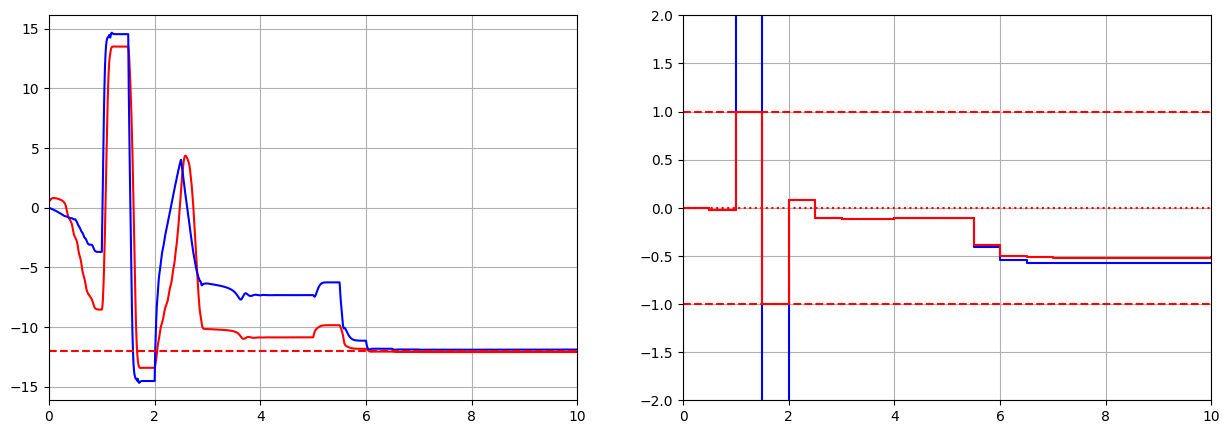

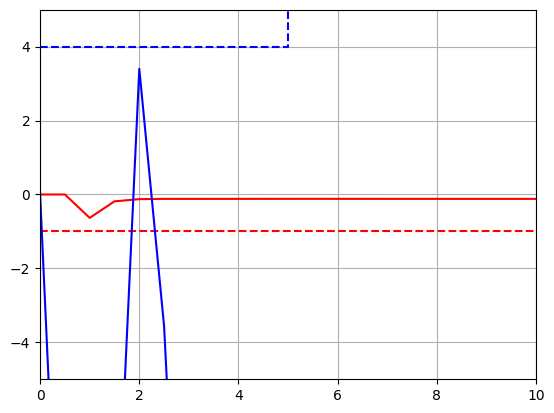

In [137]:
v0_init = 4.0
v0_finish = 23.0
change_time = 5
goal = -12
gain = 300
step = 0.5
mod_step = 0.01
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_ident(goal=goal, gain=gain, dt=step)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.coeff['t'], reg.coeff['a'], 'r', [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['b'], 'b', [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
plt.ylim([-5.0, 5.0])
plt.xlim([0, tk])
plt.grid()
plt.show()

Процесс настройки включал в себя регулировку коэффициента усиления управляющего элемента, частоту управляющего воздействия (шаг упр.возд.).

Коэффициент усиления 300 для адаптивного регулятора идентификационного типа оказался оптимальным, установившееся значение равно желаемому, система устойчива.

# 5. Система прямого адаптивного управления с обобщённой ошибкой настройки.
Уравнения объекта и регулятора основного контура (без адаптации).

$(1)\;\dot{dP}\;=\;17T\;+\;\zeta\;-\;0.1dP^3\;+\;9\sin\left(4dP\;-\;7\right)\;-\;6$

$(2)\;\dot T\;=\;-0.1T^3 - 2Tcos\left(5dP\;+\;6\right)\;+\;G\;*\;tanh\left(I\right)\;-\;1$

$I = c_1 dP + c_2 T + c_3$

Установка и импорт вспомогательных пакетов

In [69]:
!pip install digicon_mod

In [70]:
import math
import numpy
import matplotlib.pyplot as plt

import digicon_mod

## 1. Определение вспомогательных объектов в Python
Определяем модель объекта.

In [124]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc):
        def F_internal(x, t):
            if t > step_time:
                zeta = finish_value
            else:
                zeta = init_value
            d_dP=17 * x[1] + zeta - 0.1 * math.pow(x[0],3) + 9 * math.sin(4 * x[0] - 7) - 6
            dT=-0.1 * math.pow(x[1],3) - 2 * x[1] * math.cos(5 * x[0] + 6) + uc - 1
            return [d_dP, dT]

        return F_internal
    return F_with_control

In [125]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(time,x1, 'r-', time, x2, 'b-')
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--')
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t,plc.u_lim,'r-')
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')
    plt.ylim([-2.0, 2.0])
    plt.show()

Базовый класс для реализации регулятора, программа моделирования и вывода результатов на экран.

### 2. Адаптивный регулятор с обобщённой ошибкой настройки
Реализация алгоритма адаптивного управления.

In [126]:
class ADCS_gerr(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_gerr,self).__init__(gain,step=dt)
        self.g = speed
        self.P_d = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'dy':[], 'ddy':[], 'sigma':[]}
        self.y_last = None
        self.y_last_last = None

    def optimize(self, x, t):
        y = x[0] - self.P_d
        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        if self.y_last_last is not None:
            dy = (y - self.y_last)/self.dt
            ddy = (y - 2.0*self.y_last + self.y_last_last) / (self.dt**2)
            sigma = ddy + 3.0*dy + 2.0*y
            self.coeff['sigma'].append(sigma)

            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]

            c1 = c1 - self.g*sigma*x[0]
            c2 = c2 - self.g*sigma*x[1]
            c3 = c3 - self.g*sigma

            self.coeff['c1'].append(c1)
            self.coeff['c2'].append(c2)
            self.coeff['c3'].append(c3)
        else:
            self.coeff['sigma'].append(0.0)
            self.coeff['c1'].append(self.c10)
            self.coeff['c2'].append(self.c20)
            self.coeff['c3'].append(self.c30)

        if self.y_last is not None:
            self.y_last_last = self.y_last

        self.y_last = y

    def control(self, x, t):
        self.optimize(x, t)

        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]

        return c1*x[0] + c2*x[1] + c3

Моделирование регулятора с функцией обобщённой ошибки

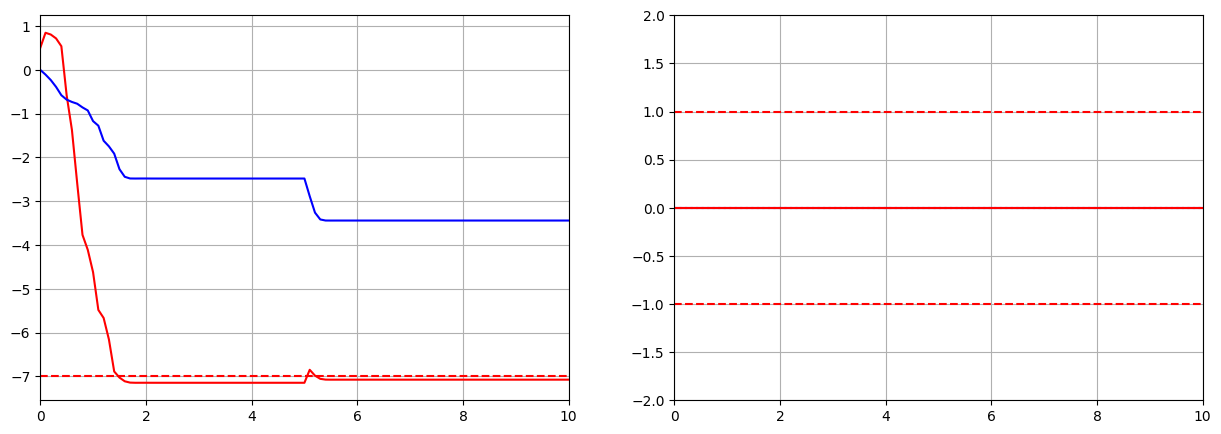

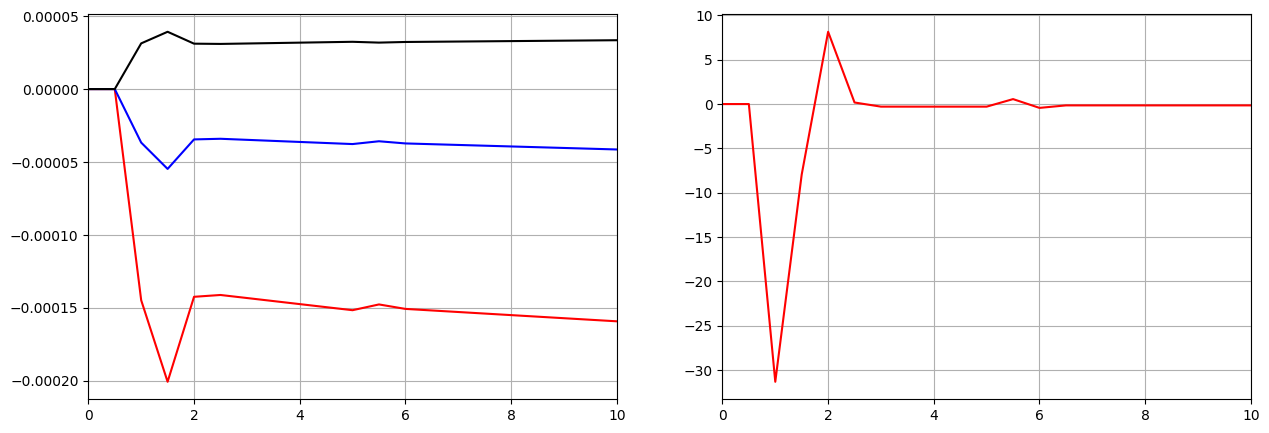

In [134]:
v0_init = 4.0
v0_finish = 23.0
change_time = 5
goal = -7
gain = 30
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_gerr(goal=goal, gain=gain, dt=step, speed=0.000001)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',# [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['c2'], 'b',# [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['sigma'], 'r')# [0, tk], [-1, -1], 'r--',
plt.grid()
plt.xlim([0, tk])
plt.show()

Путём подбора коэффициентов gain, speed, mod_step пришли к наилучшему варианту регулятора.

В итоге оптимальные значения gain = 30, speed = 0.000001, mod_step = 0.1

# 6. Система прямого адаптивного управления на основе метода скоростного градиента.

Программа расчета управления

In [75]:
class ADCS_spgrad(digicon_mod.plc.PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_spgrad,self).__init__(gain, dt)
        self.g = speed
        self.P_d = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'y':[], 'Q':[]}

    def optimize(self, x, t):
        y = x[0] - self.P_d
        Q = y**2

        self.coeff['t'].append(t)
        self.coeff['y'].append(y)
        self.coeff['Q'].append(Q)

        if len(self.coeff['c1'])>0:
            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]
        else:
            c1 = 0.0
            c2 = 0.0
            c3 = 0.0

        c1 = c1 - self.g*y*x[0]
        c2 = c2 - self.g*y*x[1]
        c3 = c3 - self.g*y

        self.coeff['c1'].append(c1)
        self.coeff['c2'].append(c2)
        self.coeff['c3'].append(c3)

    def control(self, x, t):
        self.optimize(x, t)

        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]

        return c1*x[0] + c2*x[1] + c3

Моделирование системы с регулятором

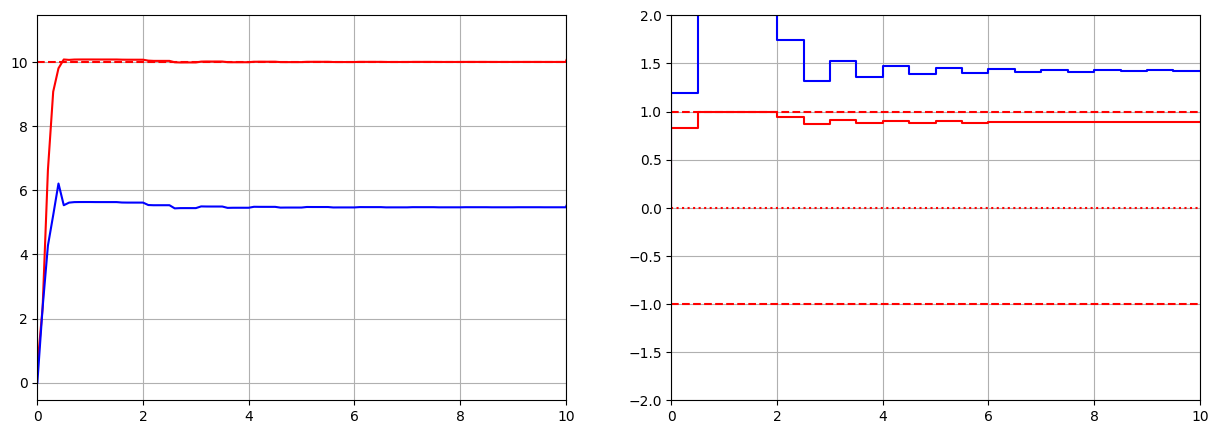

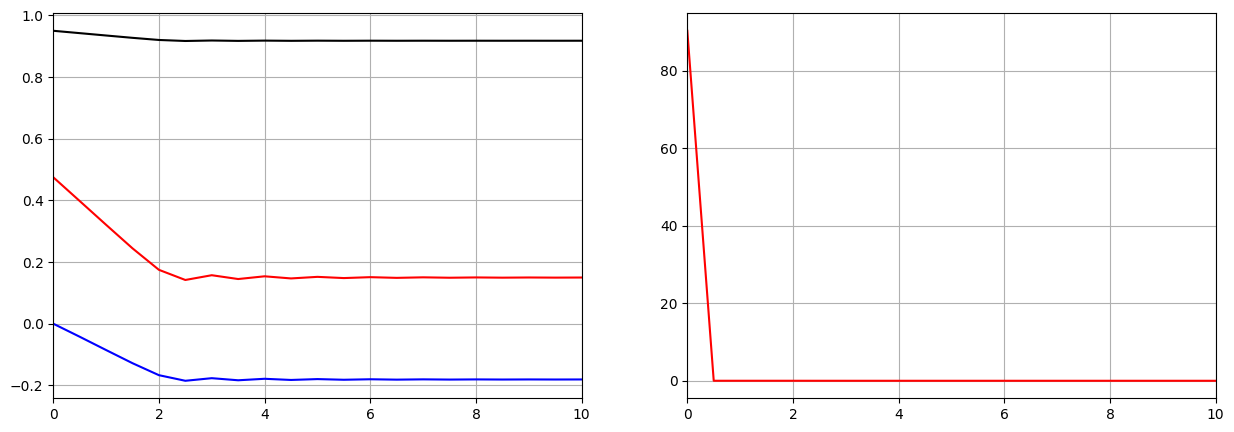

In [76]:
v0_init = 4.0
v0_finish = 23.0
change_time = 10
goal = 10
gain = 30
step = 0.5
mod_step = 0.1
tk = 10
x0 = [0.5, 0.0]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_spgrad(goal=goal, gain=gain, dt=step, speed=0.1)
res = digicon_mod.sim.calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',
         reg.coeff['t'], reg.coeff['c2'], 'b',
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['Q'], 'r')
plt.grid()
plt.xlim([0, tk])
plt.show()

Путём подбора коэффициентов gain, speed, mod_step пришли к наилучшему варианту регулятора.\
Закон управлению по методу градиентного спуска гораздо лучше приводит систему к желаемому значению, в отличии от метода с обобщённой ошибкой настройки.

В итоге оптимальные значения gain = 30, speed = 0.1, mod_step = 0.1

# 7. Выводы

В результате выполнения курсового проекта было произведено моделирование различных типов регуляторов для заданной системы управления.

В том числе:

• система с ПИД‐регулятором,

• метод АКАР с фиксацией неизвестного параметра на уровне среднего,

• метод АКАР с интегральной адаптацией,

• метод АКАР с идентификацией неизмеряемого параметра,

• система прямого адаптивного управления с обобщённой ошибкой настройки,

• система прямого адаптивного управления на основе метода скоростного градиента.

В ходе моделирования установлены корректные параметры для поддержания работоспособности того или иного регулятора. К числу таких параметров относятся: частота управляющего воздействия, коэффициент усиления управляющего элемента, начальные условия системы, горизонт моделирования во времени.

Произведен анализ особенностей каждого метода, выявлены сильные и слабые стороны различных подходов к построению адаптивных систем управления.